Import Relevant Libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


Inspect Data

In [3]:
resale_approval_full = pd.read_csv("data/fixed_resale_with_bus.csv", index_col=0)

Our raw dataset looks as such:

In [4]:
resale_approval_full.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,busstops
index,,,,,,,,,,,
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,0.0
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,0.0
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,0.0
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,0.0
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,1.0


A look at summary statistics for resale by registration and approval

In [5]:
resale_approval_full.describe()

,floor_area_sqm,lease_commence_date,resale_price,busstops
count,656851.000000,656851.000000,656851.000000,656851.000000
mean,95.171843,1985.895573,254281.174816,2.483970
std,26.432940,8.285107,123254.959795,1.540395
min,28.000000,1966.000000,5000.000000,0.000000
25%,70.000000,1980.000000,163000.000000,2.000000
50%,92.000000,1985.000000,239000.000000,2.000000
75%,115.000000,1992.000000,330000.000000,4.000000
max,307.000000,2012.000000,903000.000000,10.000000


### Data Processing

In [6]:
resale_approval_full.count()

month                  656851
town                   656851
flat_type              656851
block                  656851
street_name            656851
storey_range           656851
floor_area_sqm         656851
flat_model             656851
lease_commence_date    656851
resale_price           656851
busstops               656851
dtype: int64

In [7]:
## A function that would be flexible enough to transform categorical datasets.
## Note: Some preprocessing probably needs to be done, to convert some string variables to float
from housing.preprocess import *

Preprocessing data on resale_approval_full

In [8]:
def commence_date_to_remaining(year: int):
    import datetime
    return 99 - (datetime.datetime.now().year - year)

def months_since1990(s:str):
    ## months are in this format: YYYY-MM
    YYMM =s.split('-')
    return (12 * (int(YYMM[0]) - 1990) + (int(YYMM[1]))) 

## using process_data() on resale_approval_full
resale_approval_full = pd.read_csv("data/fixed_resale_with_bus.csv", index_col=0)
resale_approval_full['month_index_since_1990'] = resale_approval_full['month'].apply(months_since1990)
resale_approval_full['flat_type'] = resale_approval_full['flat_type'].apply(lambda x: x.lower())
resale_approval_full['lease_remaining'] = resale_approval_full['lease_commence_date'].apply(commence_date_to_remaining)
# resale_approval_full = resale_approval_full.drop(["block", "lease_commence_date"], axis=1)

In [9]:
resale_approval_full.tail()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,busstops,month_index_since_1990,lease_remaining
index,,,,,,,,,,,,,
656846,2012-02,YISHUN,5 room,212,YISHUN ST 21,10 TO 12,121.0,Improved,1985,476888.0,2.0,266,64
656847,2012-02,YISHUN,5 room,758,YISHUN ST 72,01 TO 03,122.0,Improved,1986,490000.0,3.0,266,65
656848,2012-02,YISHUN,5 room,873,YISHUN ST 81,01 TO 03,122.0,Improved,1988,488000.0,1.0,266,67
656849,2012-02,YISHUN,executive,664,YISHUN AVE 4,07 TO 09,181.0,Apartment,1992,705000.0,3.0,266,71
656850,2012-02,YISHUN,executive,293,YISHUN ST 22,04 TO 06,163.0,Apartment,1992,630000.0,2.0,266,71


In [10]:
unique_flats = resale_approval_full[["block", "street_name", "storey_range"]].drop_duplicates()
unique_flats.shape

(38578, 3)

### Getting variables that follow a time series

As explained in the report, we aren't using time-series models to fit the data and yet we need time-series dependent variables such as:
- last known resale price 
- time since the last resale price

We get a subset of each unique block in the dataset, lag it and concatnate the final datasets 

In [11]:
## lag_housing_df takes resale_approval_full above and does the above step
# lag_housing_df(resale_approval_full) 

In [12]:
## data was written to csv previously so we just load from it
lagged_data = pd.read_csv("data/lagged_approval.csv", index_col=0)
print(lagged_data.shape)
lagged_data.head()

(618273, 15)


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,busstops,month_index_since_1990,lease_remaining,last_known_price,months_since_last
0,1990-01,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,0.0,1,56,9000.0,0.0
1,1990-05,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,7800.0,0.0,5,56,8000.0,4.0
2,1990-08,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9500.0,0.0,8,56,7800.0,3.0
3,1990-09,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9500.0,0.0,9,56,9500.0,1.0
4,1990-10,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,5800.0,0.0,10,56,9500.0,1.0


Next code block adds **GDP** for the year which the resale occued

In [13]:
gdp_data = get_processed_gdp_data()
gdp_data[gdp_data["year"] >= 1990].head()

,year,GDP_value,GDP_perc_change
30,1990,70492.3,14.979652
31,1991,78542.8,11.420396
32,1992,84920.2,8.119649
33,1993,97923.1,15.311905
34,1994,112555.4,14.942644


In [14]:
lagged_data["year"] = lagged_data["month"].apply(lambda x: int(x[:x.rfind('-')]))
lagged_data = lagged_data.merge(gdp_data, on=["year"])

In [15]:
full_df_subset = lagged_data.copy(deep=True)
# full_df_subset["flat"] = full_df_subset["block"] + " " + full_df_subset["street_name"]
# full_df_subset.drop(["block", "street_name", "month"], axis=1, inplace=True)
full_df_subset.drop(["block", "month", "lease_commence_date"], axis=1, inplace=True)
print(full_df_subset.shape)
full_df_subset.head()

(618273, 15)


,town,flat_type,street_name,storey_range,floor_area_sqm,flat_model,resale_price,busstops,month_index_since_1990,lease_remaining,last_known_price,months_since_last,year,GDP_value,GDP_perc_change
0,ANG MO KIO,1 room,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,8000.0,0.0,1,56,9000.0,0.0,1990,70492.3,14.979652
1,ANG MO KIO,1 room,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,7800.0,0.0,5,56,8000.0,4.0,1990,70492.3,14.979652
2,ANG MO KIO,1 room,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,9500.0,0.0,8,56,7800.0,3.0,1990,70492.3,14.979652
3,ANG MO KIO,1 room,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,9500.0,0.0,9,56,9500.0,1.0,1990,70492.3,14.979652
4,ANG MO KIO,1 room,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,5800.0,0.0,10,56,9500.0,1.0,1990,70492.3,14.979652


In [10]:
## run if data/final_df.csv is not available
full_df_subset = lagged_data.copy(deep=True)

final_lagged_data = pd.read_csv("data/resale_with_location_final.csv", index_col=0)
intersection_col = list(set(lagged_data.columns) & set(final_lagged_data))
print(intersection_col)
facilities = final_lagged_data[["block", "street_name", "lrt", "mrt", "shopping_malls"]].drop_duplicates()
print("facilities.shape =",facilities.shape)
final_df = full_df_subset.merge(facilities, on=["block", "street_name"])
final_df.to_csv("data/final_df.csv")

['flat_type', 'lease_commence_date', 'block', 'flat_model', 'busstops', 'resale_price', 'town', 'street_name', 'floor_area_sqm', 'storey_range']
facilities.shape = (8416, 5)


In [11]:
print(final_df.shape)
print(lagged_data.shape)

(618273, 21)
(618273, 18)


In [16]:
final_df = pd.read_csv("data/final_df.csv", index_col=0)
# final_df.set_index("month", drop=True, inplace=True)
print(final_df.shape)
final_df.head()

c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(618273, 21)


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,...,month_index_since_1990,lease_remaining,last_known_price,months_since_last,year,GDP_value,GDP_perc_change,lrt,mrt,shopping_malls
0,1990-01,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,...,1,56,9000.0,0.0,1990,70492.3,14.979652,0,0,0
1,1990-05,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,7800.0,...,5,56,8000.0,4.0,1990,70492.3,14.979652,0,0,0
2,1990-08,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9500.0,...,8,56,7800.0,3.0,1990,70492.3,14.979652,0,0,0
3,1990-09,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9500.0,...,9,56,9500.0,1.0,1990,70492.3,14.979652,0,0,0
4,1990-10,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,5800.0,...,10,56,9500.0,1.0,1990,70492.3,14.979652,0,0,0


Inspecting for multicollinearity:

Plot correlation matrix for predictors only to look for strong/perfect correlation
between variables and delete if necessary

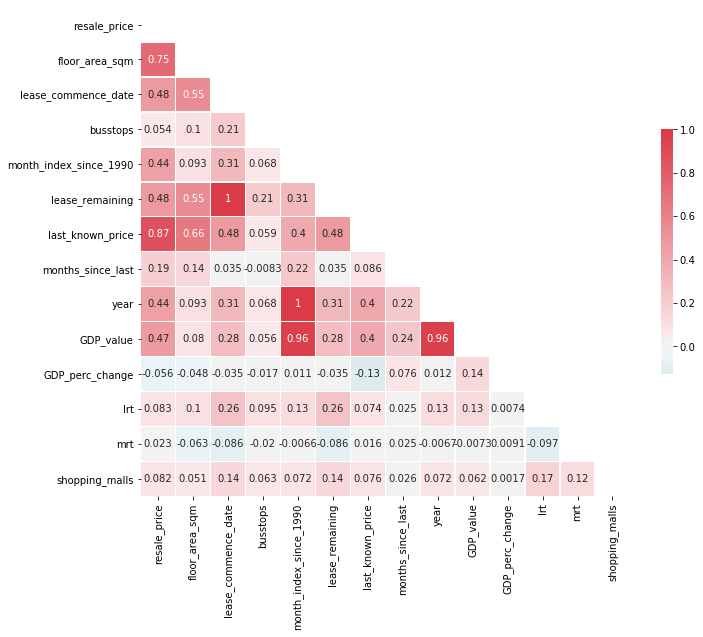

In [17]:
variables = list(final_df.columns)
del variables[9]

final_df_corr = final_df[['resale_price'] + variables].corr()
f, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(final_df_corr, dtype=np.bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(final_df_corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

While `busstops` are uncorrelated with `resale_price` , we can do it after looking at the significance of busstops in predicting `resale_price`.

The following plot looks at the plot of housing prices with time. As there are many units, we look at 3 random flats. 

c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


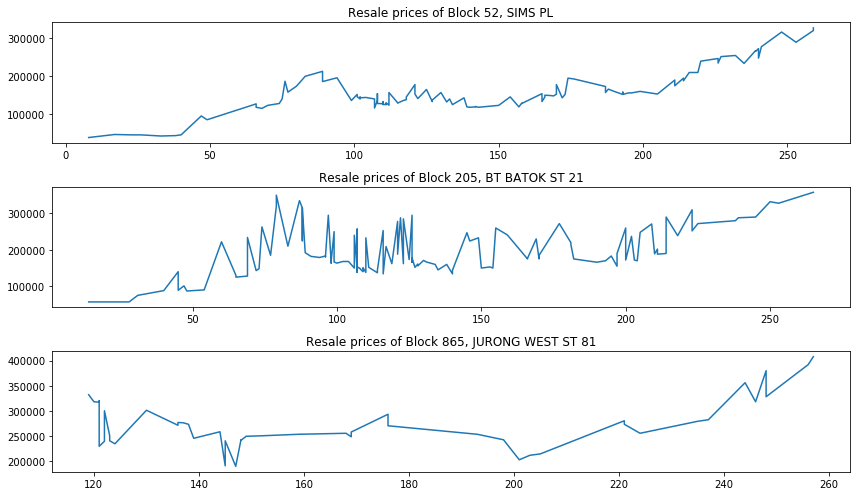

In [18]:
import random
plt.figure(figsize=(12,7))

for i in range(3):
    plt.subplot(3,1,i+1)
    idx = random.randint(0,final_df.shape[0])
    block = final_df["block"][idx]
    street_name = final_df["street_name"][idx]
    flat = final_df[(final_df["street_name"] ==street_name) & (final_df["block"] == block)]
    flat.sort_values(by="month_index_since_1990", inplace=True)
    plt.plot(flat["month_index_since_1990"],flat["resale_price"])
    plt.title(f"Resale prices of Block {block}, {street_name}")
plt.tight_layout()

In [19]:
final_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,...,month_index_since_1990,lease_remaining,last_known_price,months_since_last,year,GDP_value,GDP_perc_change,lrt,mrt,shopping_malls
0,1990-01,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,...,1,56,9000.0,0.0,1990,70492.3,14.979652,0,0,0
1,1990-05,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,7800.0,...,5,56,8000.0,4.0,1990,70492.3,14.979652,0,0,0
2,1990-08,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9500.0,...,8,56,7800.0,3.0,1990,70492.3,14.979652,0,0,0
3,1990-09,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9500.0,...,9,56,9500.0,1.0,1990,70492.3,14.979652,0,0,0
4,1990-10,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,5800.0,...,10,56,9500.0,1.0,1990,70492.3,14.979652,0,0,0


### Model fitting - ML Techniques

In [20]:
'''
process data to fit model fitting techniques
'''
final_df.drop(["month","year","block", "lease_commence_date"], axis=1, inplace=True)

# lb_cols = ["flat_model", "flat", "town"]
lb_cols = ["flat_model", "street_name", "town"]
le_cols = ["flat_type", "storey_range"]
approval = process_data(final_df, lb_cols=lb_cols, le_cols=le_cols)
print(approval.shape)

X_approval = approval.drop("resale_price", axis=1)
y_approval = approval["resale_price"]

(618273, 600)


In [21]:
## functions to fit ML_models
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import Lasso, BayesianRidge
from sklearn.model_selection import train_test_split, GridSearchCV

## code is in housing/ML.py
from housing.ML import ML_Model

def split_df(X, y):
    return train_test_split(X, y, test_size=0.25)

Cross validation was not used because of memory overflow on the huge dataset but can be done if more memory is available.

In [14]:
## cross validation to obtain parameters that fit the model best

# from sklearn.model_selection import cross_validate

# lasso = Lasso(warm_start=True)
# br = BayesianRidge()
# # lasso_cv = GridSearchCV(estimator=lasso, param_grid={
# #     "alpha": [0.5,1., 5],
# # },n_jobs=-1, verbose=2)

# br_cv = GridSearchCV(estimator=br, param_grid={
#     "alpha_1": [1e-7, 1e-6, 4e-6, 1e-5],
#     "alpha_2" : [1e-7, 1e-6, 4e-6, 1e-5],
#     "lambda_1" : [1e-7, 1e-6, 4e-6, 1e-5],
#     "lambda_2" : [1e-7, 1e-6, 4e-6, 1e-5],
# },n_jobs=-1)

# # lasso_cv.fit(X_approval,y_approval)
# # print("lasso GridSearchCV done")
# br_cv.fit(X_approval, y_approval)

# print("Lasso Results:\n\n", lasso_cv.cv_results_)
# print("Br Results:\n\n", br_cv.cv_results_)

# print(lasso_cv.best_params_)
# print(br_cv.best_params_)

In [9]:
## ML techniques - Lasso
lasso = Lasso(warm_start=True)
lasso_model = ML_Model(lasso, X_approval, y_approval, split_df)
# lasso_model.fit()
lasso_model.fit_multiple(5)
lasso_model.get_metrics()
# lasso.fit(X_train,y_train)
# print(lasso.score(X_train, y_train))

c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 347325880248420.4, tolerance: 680735039961.7593
  positive)


Adding fitted regression metrics ...


c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 342024891140838.5, tolerance: 679732494556.4001
  positive)


Adding fitted regression metrics ...


c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 338443255612382.1, tolerance: 682407197101.5845
  positive)


Adding fitted regression metrics ...


c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 316112220372415.4, tolerance: 681029979249.3157
  positive)


Adding fitted regression metrics ...
Adding fitted regression metrics ...


{'fitted_metrics': {'MSE': 1503970588.491368,
  'Explained Variance': 0.8975489371552214,
  'R^2': 0.8975489371552214,
  'MAE': 28831.061447076216,
  'MSPE': -3.3228737403687325,
  'RMSE': array([38781.05966179])}}

In [22]:
## ML techniques - Bayesian Ridge
br = BayesianRidge()
br_model = ML_Model(br, X_approval, y_approval, split_df)
br_model.fit_multiple(5)
br_model.get_metrics()

Adding fitted regression metrics ...
Adding fitted regression metrics ...
Adding fitted regression metrics ...
Adding fitted regression metrics ...
Adding fitted regression metrics ...


{'fitted_metrics': {'MSE': 1504520740.673114,
  'Explained Variance': 0.897556278965688,
  'R^2': 0.897556278965688,
  'MAE': 28828.945147050184,
  'MSPE': 3.327312466420847,
  'RMSE': 38788.15206571607}}

### Deep Learning Techniques

#### ANN

In [23]:
X_train, X_test, y_train, y_test = split_df(X_approval, y_approval)
# df = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values)).batch(16)

## model definition
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=[X_train.shape[1]]),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
])
model.compile(optimizer='adam',
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               76800     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 85,717
Trainable params: 85,717
Non-trainable params: 0
_________________________________________________________________


In [58]:
## training code. Skip this if there is pre-trained model already
EPOCHS = 100

history = model.fit(
  X_train, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=2)

## save model
model.save_weights("./checkpoints/ann-epoch-100")

Train on 370963 samples, validate on 92741 samples
Epoch 1/100
370963/370963 - 50s - loss: 3447286920.6956 - mse: 3447280128.0000 - val_loss: 3244787822.2867 - val_mse: 3244788224.0000
Epoch 2/100
370963/370963 - 48s - loss: 3034022297.7747 - mse: 3034023680.0000 - val_loss: 2803769352.8608 - val_mse: 2803768832.0000
Epoch 3/100
370963/370963 - 48s - loss: 2770714002.4666 - mse: 2770713600.0000 - val_loss: 2649099199.5093 - val_mse: 2649097216.0000
Epoch 4/100
370963/370963 - 48s - loss: 2599887695.5777 - mse: 2599887104.0000 - val_loss: 2378468175.5388 - val_mse: 2378470912.0000
Epoch 5/100
370963/370963 - 48s - loss: 2414514800.1889 - mse: 2414517248.0000 - val_loss: 2211344053.5679 - val_mse: 2211345408.0000
Epoch 6/100
370963/370963 - 49s - loss: 2273143400.7943 - mse: 2273140224.0000 - val_loss: 2119805405.8624 - val_mse: 2119805184.0000
Epoch 7/100
370963/370963 - 49s - loss: 2157785081.8789 - mse: 2157783296.0000 - val_loss: 1992559490.4830 - val_mse: 1992559616.0000
Epoch 8/100

Epoch 62/100
370963/370963 - 51s - loss: 1223076995.0737 - mse: 1223076096.0000 - val_loss: 1104402973.0654 - val_mse: 1104402304.0000
Epoch 63/100
370963/370963 - 51s - loss: 1195211769.6032 - mse: 1195210880.0000 - val_loss: 1004533237.4112 - val_mse: 1004531968.0000
Epoch 64/100
370963/370963 - 50s - loss: 1198007280.1582 - mse: 1198006016.0000 - val_loss: 1185493035.4975 - val_mse: 1185493376.0000
Epoch 65/100
370963/370963 - 50s - loss: 1186216426.5932 - mse: 1186218240.0000 - val_loss: 1758408866.5834 - val_mse: 1758410240.0000
Epoch 66/100
370963/370963 - 50s - loss: 1187714817.8991 - mse: 1187716096.0000 - val_loss: 1352742328.4921 - val_mse: 1352742784.0000
Epoch 67/100
370963/370963 - 50s - loss: 1181425246.8752 - mse: 1181424768.0000 - val_loss: 1607600722.6760 - val_mse: 1607601280.0000
Epoch 68/100
370963/370963 - 256s - loss: 1168176210.1483 - mse: 1168174208.0000 - val_loss: 1072634745.8316 - val_mse: 1072635072.0000
Epoch 69/100
370963/370963 - 50s - loss: 1172150682.87

### Checking Model Assumptions

In this section, we look at whether the fitted model satifies assumptions in the underlying model. 

For example, regression requires data to be homoscedastic. We observe this in a residual plot or QQ-plot, where residuals should look like a random variable with mean 0 while QQ-plot should show a straight line.

**Residual Plot**

In [24]:
from housing.ModelChecking import *
from housing.statplots import statplots

# statplots_lasso = statplots(fitted_y=br_model.predict(br_model.X_train), 
#                         test_y= br_model.y_train,
#                         index= br_model.y_train.index,
#                         model= lasso_model,
#                         X=br_model.X_train)
statplots_br = statplots(fitted_y=br_model.predict(br_model.X_train), 
                        test_y= br_model.y_train,
                        index= br_model.y_train.index,
                        model= br_model,
                        X=br_model.X_train)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

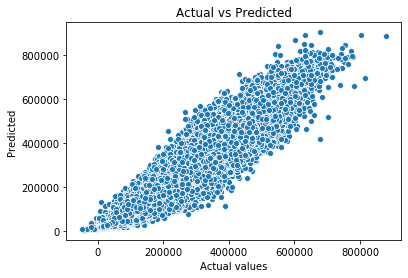

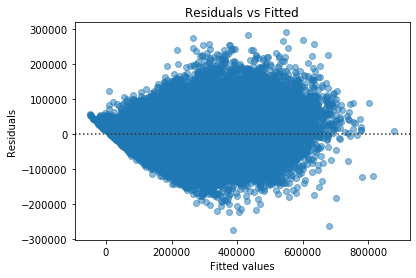

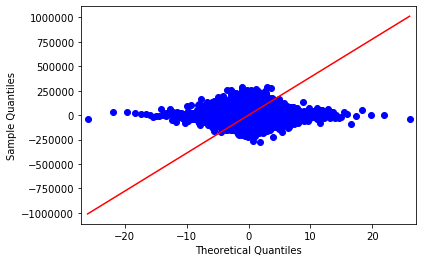

In [25]:
statistical_plots(br_model.preds, br_model.y_test)

In [24]:
AIC_BIC(br_model.preds, br_model.y_test, X_approval.shape[1]+1)

(1127.8298890627652, 3274205.5286683333)

### **Model Performance**
- Looking at regression metrics on OOB data

In [11]:
## fitting test values and getting regression performance statistics
lasso_preds = lasso_model.predict_test()
br_preds = br_model.predict_test()

Adding OOB regression metrics ...
Adding OOB regression metrics ...


In [13]:
br_model.get_metrics()

{'fitted_metrics': {'MSE': 1502595888.892615,
  'Explained Variance': 0.8976799395347832,
  'R^2': 0.8976799395347832,
  'MAE': 28816.165963572734,
  'MSPE': -3.322059527308563,
  'RMSE': array([38763.33175686])},
 'test_metrics': {'MSE': 1503349263.048181,
  'Explained Variance': 0.8978396623662471,
  'R^2': 0.897838796130808,
  'MAE': 28825.791967386285,
  'RMSE': array([38773.04815266]),
  'MSPE': 2.300706410058545}}

In [14]:
lasso_model.get_metrics()

{'fitted_metrics': {'MSE': 1503970588.491368,
  'Explained Variance': 0.8975489371552214,
  'R^2': 0.8975489371552214,
  'MAE': 28831.061447076216,
  'MSPE': -3.3228737403687325,
  'RMSE': array([38781.05966179])},
 'test_metrics': {'MSE': 1516263806.4344075,
  'Explained Variance': 0.8973730782423266,
  'R^2': 0.8973730334622514,
  'MAE': 28882.62774134478,
  'RMSE': array([38939.23222708]),
  'MSPE': 2.3228620817265915}}

In [72]:
## prediction
model.load_weights("./checkpoints/ann-epoch-100")
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
print("MSE: ",mean_squared_error(y_pred, y_test))
print("RMSE: ", np.sqrt([mean_squared_error(y_pred, y_test)]))
print("MAE: ", mean_absolute_error(y_pred, y_test))
print("Explained Variance: ", explained_variance_score(y_pred, y_test))
print("MAPE: ", np.average(np.divide((np.reshape(y_pred, (1,-1))[0] - np.array(y_test)) ,y_test))*100)

MSE:  1284553965.9057705
RMSE:  [35840.67474122]
MAE:  26310.550820737575
Explained Variance:  0.9290026400224778
MAPE:  7.690866123023496


The **ANN model** gives the lowest RMSE and hence would be the best model to forecast housing resale prices.

Looking at Explained Variance, ANN explains most of the variance in the test observations as well.

### Further Improvements

In [6]:
'''
Instead of putting the past price as a predictor, we let the predictor be a differential of the previous known price, similar to getting differentials in ARIMA models. 

We compare this method against the former method, to see which method is better in prediction with a possible explanation
'''
differential_df = final_df.copy(deep=True)
differential_df["price_difference"] = differential_df["resale_price"] - differential_df["last_known_price"]
differential_df.drop(["resale_price", "last_known_price"], axis=1, inplace=True)

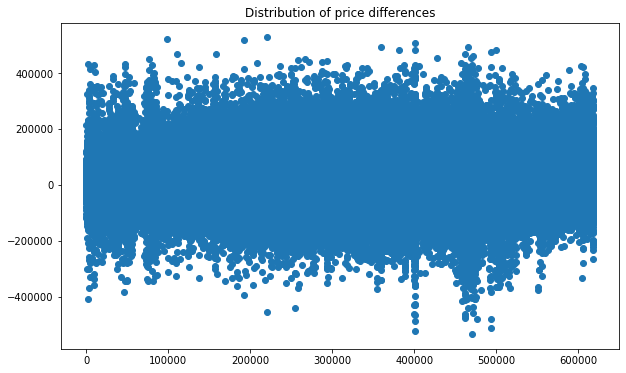

In [9]:
plt.figure(figsize=(10,6))
plt.title("Distribution of price differences")
plt.scatter(differential_df.index, differential_df["price_difference"])

As stated in the report, there could be a possibility of applying time series models if the data were to be more consistent - there's observation for regular time intervals (eg. month, year). The above plot shows the first difference between resale prices and it is clear that the first difference is stationary, allowing usage for time-series methods such as **ARIMA(p,1,q)** on better datasets in the future.